In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV

In [ ]:
data = pd.read_csv('https://zenodo.org/records/4561253/files/WELFake_Dataset.csv')
print(data.head())

   Unnamed: 0                                              title  \
0           0  LAW ENFORCEMENT ON HIGH ALERT Following Threat...   
1           1                                                NaN   
2           2  UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...   
3           3  Bobby Jindal, raised Hindu, uses story of Chri...   
4           4  SATAN 2: Russia unvelis an image of its terrif...   

                                                text  label  
0  No comment is expected from Barack Obama Membe...      1  
1     Did they post their votes for Hillary already?      1  
2   Now, most of the demonstrators gathered last ...      1  
3  A dozen politically active pastors came here f...      0  
4  The RS-28 Sarmat missile, dubbed Satan 2, will...      1  


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72134 entries, 0 to 72133
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  72134 non-null  int64 
 1   title       71576 non-null  object
 2   text        72095 non-null  object
 3   label       72134 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 2.2+ MB


**Preprocessing**
Delete all null data

In [ ]:
data = data.drop(["title", "Unnamed: 0"], axis = 1)
print(data.isnull().sum())
data.dropna(subset=['text'], inplace=True)
data = data.sample(frac=1)
data.reset_index(inplace=True)
data.drop(["index"], axis=1, inplace=True)

text     39
label     0
dtype: int64


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72095 entries, 0 to 72094
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    72095 non-null  object
 1   label   72095 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


0 = Hoax
1 = True News

Mencari banyak data yang labelnya 0 dan yang labelnya 1

<Axes: xlabel='label', ylabel='count'>

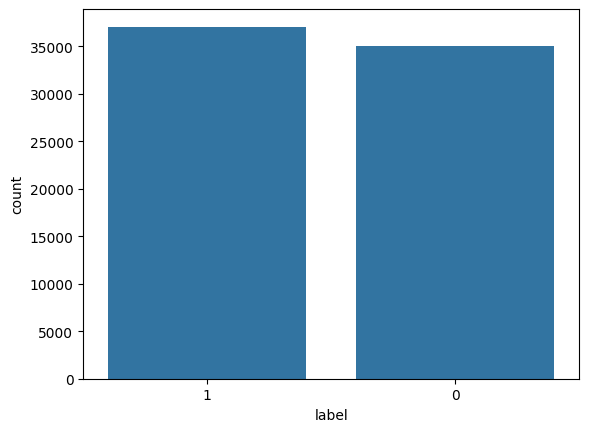

In [ ]:
sns.countplot(data=data, x='label', order=data['label'].value_counts().index)

In [ ]:
print(data["label"].value_counts());

label
1    37067
0    35028
Name: count, dtype: int64


Importing Tokenizer library

In [ ]:
from tqdm import tqdm

import re

import nltk

nltk.download('punkt')

nltk.download('stopwords')

from nltk.corpus import stopwords

from nltk.tokenize import word_tokenize

from nltk.stem.porter import PorterStemmer

from wordcloud import WordCloud


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Membuat Fungsi untuk memisahkan tiap kata dalam kolom text

In [ ]:
def preprocess_text(text_data):

    preprocessed_text = []



    for sentence in tqdm(text_data):

        sentence = re.sub(r'[^\w\s]', '', sentence)
        # sentence = re.sub('[^a-zA-Z]', ' ', sentence)


        preprocessed_text.append(' '.join(token.lower()

                                  for token in str(sentence).split()

                                  if token not in stopwords.words('english')))



    return preprocessed_text

100%|██████████| 72095/72095 [1:25:34<00:00, 14.04it/s]


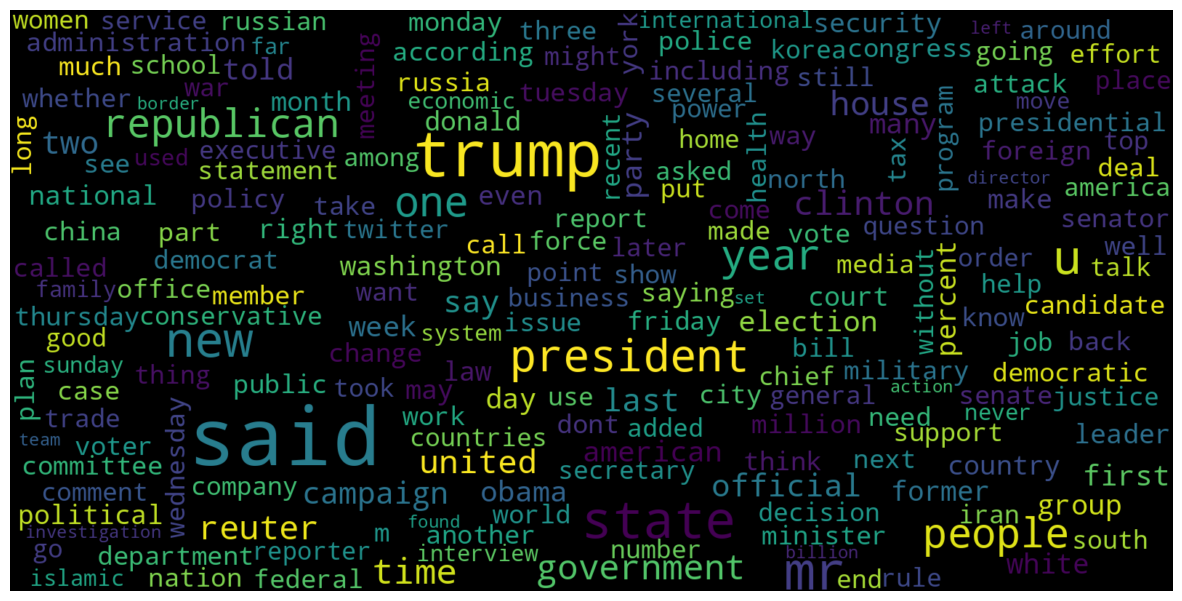

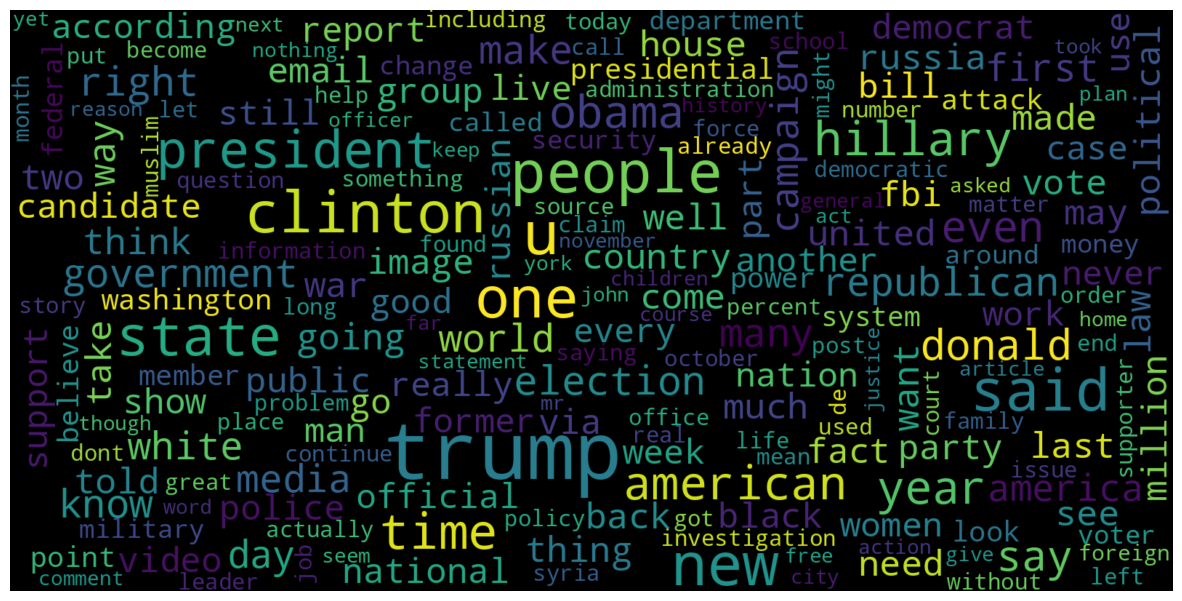

In [ ]:
# menjalankan fungsi tersebut untuk filter dataset yang akan digunakan
preprocessed_review = preprocess_text(data['text'].values)
data['text'] = preprocessed_review

# melihat kata - kata yang sering muncul pada berita

# Real

consolidated = ' '.join(

    word for word in data['text'][data['label'] == 0].astype(str))

wordCloud = WordCloud(width=1600,

                      height=800,

                      random_state=21,

                      max_font_size=110,

                      collocations=False)

plt.figure(figsize=(15, 10))

plt.imshow(wordCloud.generate(consolidated), interpolation='bilinear')

plt.axis('off')
plt.show()


# Fake

consolidated = ' '.join(

    word for word in data['text'][data['label'] == 1].astype(str))

wordCloud = WordCloud(width=1600,

                      height=800,

                      random_state=21,

                      max_font_size=110,

                      collocations=False)

plt.figure(figsize=(15, 10))

plt.imshow(wordCloud.generate(consolidated), interpolation='bilinear')

plt.axis('off')
plt.show()



Mencari kata kata dengan penggunaan paling tinggi

<Axes: title={'center': 'Bar Chart of Top Words Frequency'}, xlabel='Top Words', ylabel='Count'>

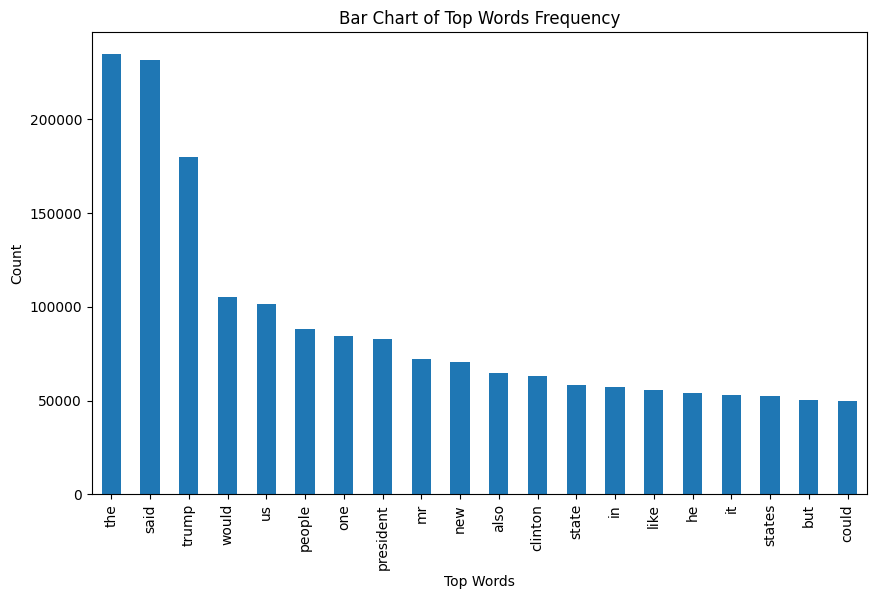

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
def get_top_n_words(corpus, n=None):

    vec = CountVectorizer().fit(corpus)

    bag_of_words = vec.transform(corpus)

    sum_words = bag_of_words.sum(axis=0)

    words_freq = [(word, sum_words[0, idx])

                  for word, idx in vec.vocabulary_.items()]

    words_freq = sorted(words_freq, key=lambda x: x[1],

                        reverse=True)

    return words_freq[:n]

common_words = get_top_n_words(data['text'], 20)


df1 = pd.DataFrame(common_words, columns=['Review', 'count'])



df1.groupby('Review').sum()['count'].sort_values(ascending=False).plot(

    kind='bar',

    figsize=(10, 6),

    xlabel="Top Words",

    ylabel="Count",

    title="Bar Chart of Top Words Frequency"
)

**Split Data**

In [ ]:
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score

from sklearn.linear_model import LogisticRegression



x_train, x_test, y_train, y_test = train_test_split(data['text'],

                                                    data['label'],

                                                    test_size=0.25)


Show that composition between fake news and true news for training data is balance

In [ ]:
y_train.value_counts()

label
1    27748
0    26323
Name: count, dtype: int64

Mengconvert String ke vector agar bisa diproses model

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorization = TfidfVectorizer()

x_train = vectorization.fit_transform(x_train)

x_test = vectorization.transform(x_test)

**XG Boost**

In [ ]:
from sklearn.metrics import classification_report
target_names = ['FAKE', 'REAL']


              precision    recall  f1-score   support

        FAKE       0.98      0.96      0.97      8705
        REAL       0.96      0.98      0.97      9319

    accuracy                           0.97     18024
   macro avg       0.97      0.97      0.97     18024
weighted avg       0.97      0.97      0.97     18024



In [ ]:
import xgboost as xgb
XGB = xgb.XGBClassifier()
XGB.fit(x_train, y_train)


# testing the model

print(accuracy_score(y_train, XGB.predict(x_train)))

print(accuracy_score(y_test, XGB.predict(x_test)))
print(classification_report(y_test,XGB.predict(x_test) , target_names=target_names,digits=4))

0.9903275323186181
0.9682645361739902
              precision    recall  f1-score   support

        FAKE     0.9776    0.9562    0.9668      8705
        REAL     0.9599    0.9795    0.9696      9319

    accuracy                         0.9683     18024
   macro avg     0.9688    0.9679    0.9682     18024
weighted avg     0.9685    0.9683    0.9682     18024



In [ ]:
import xgboost as xgb
XGB = xgb.XGBClassifier(max_depth=5,learning_rate=0.01,subsample=0.5)
XGB.fit(x_train, y_train)


# testing the model

print(accuracy_score(y_train, XGB.predict(x_train)))

print(accuracy_score(y_test, XGB.predict(x_test)))
print(classification_report(y_test,XGB.predict(x_test) , target_names=target_names,digits=4))

0.9177747776072201
0.9165557035064359
              precision    recall  f1-score   support

        FAKE     0.9590    0.8642    0.9091      8705
        REAL     0.8839    0.9654    0.9229      9319

    accuracy                         0.9166     18024
   macro avg     0.9214    0.9148    0.9160     18024
weighted avg     0.9201    0.9166    0.9162     18024



In [ ]:
# param_grid = {
#     'max_depth': [3, 5, 7],
#     'learning_rate': [0.1, 0.01, 0.001],
#     'subsample': [0.5, 0.7, 1]
# }

# # Create the XGBoost model object
# xgb_model = xgb.XGBClassifier()

# # Create the GridSearchCV object
# grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='accuracy')

# # Fit the GridSearchCV object to the training data
# grid_search.fit(x_train, y_train)

# # Print the best set of hyperparameters and the corresponding score
# print("Best set of hyperparameters: ", grid_search.best_params_)
# print("Best score: ", grid_search.best_score_)

KeyboardInterrupt: 

**LR NO TUNING**

In [ ]:
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression(max_iter=1000)
LR.fit(x_train, y_train)


# testing the model

print(accuracy_score(y_train, LR.predict(x_train)))

print(accuracy_score(y_test, LR.predict(x_test)))
print(classification_report(y_test,LR.predict(x_test) , target_names=target_names,digits=4))

0.9718888128571693
0.9563359964491789
              precision    recall  f1-score   support

        FAKE     0.9602    0.9489    0.9545      8705
        REAL     0.9528    0.9633    0.9580      9319

    accuracy                         0.9563     18024
   macro avg     0.9565    0.9561    0.9563     18024
weighted avg     0.9564    0.9563    0.9563     18024



**Logistic Regression**

In [ ]:
from sklearn.linear_model import LogisticRegression
LRT = LogisticRegression(penalty='l1', solver='liblinear')
LRT.fit(x_train, y_train)


# testing the model

print(accuracy_score(y_train, LRT.predict(x_train)))

print(accuracy_score(y_test, LRT.predict(x_test)))
print(classification_report(y_test,LRT.predict(x_test) , target_names=target_names,digits=4))

0.9653788537293558
0.9606635596981802
              precision    recall  f1-score   support

        FAKE     0.9659    0.9522    0.9590      8705
        REAL     0.9559    0.9686    0.9622      9319

    accuracy                         0.9607     18024
   macro avg     0.9609    0.9604    0.9606     18024
weighted avg     0.9607    0.9607    0.9607     18024



In [ ]:
# parameter={"penalty":['l2', 'l1', 'elasticnet'],
#            "solver":['lbfgs', 'liblinear', 'newton-cg', 'sag', 'saga']}
# search=GridSearchCV(model, parameter)
# search.fit(x_train,y_train)
# print("Best parameter:",search.best_params_ )
# print("Best score:",search.best_score_)

**Decision Tree**

In [ ]:
from sklearn.tree import DecisionTreeClassifier



DT = DecisionTreeClassifier()
DT.fit(x_train, y_train)


# testing the model

print(accuracy_score(y_train, DT.predict(x_train)))

print(accuracy_score(y_test, DT.predict(x_test)))

print(classification_report(y_test,DT.predict(x_test) , target_names=target_names,digits=4))

1.0
0.929427430093209
              precision    recall  f1-score   support

        FAKE     0.9316    0.9215    0.9265      8705
        REAL     0.9274    0.9368    0.9321      9319

    accuracy                         0.9294     18024
   macro avg     0.9295    0.9292    0.9293     18024
weighted avg     0.9294    0.9294    0.9294     18024



In [ ]:
from sklearn.tree import DecisionTreeClassifier



DTT = DecisionTreeClassifier(random_state = 42, max_leaf_nodes=100)
DTT.fit(x_train, y_train)


# testing the model

print(accuracy_score(y_train, DTT.predict(x_train)))

print(accuracy_score(y_test, DTT.predict(x_test)))

print(classification_report(y_test,DTT.predict(x_test) , target_names=target_names,digits=4))

0.9355292115921658
0.9234909010208611
              precision    recall  f1-score   support

        FAKE     0.9339    0.9057    0.9196      8705
        REAL     0.9143    0.9401    0.9270      9319

    accuracy                         0.9235     18024
   macro avg     0.9241    0.9229    0.9233     18024
weighted avg     0.9238    0.9235    0.9234     18024



**Random Forest Classifier**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

RFC = RandomForestClassifier()
RFC.fit(x_train, y_train)

print(accuracy_score(y_train, RFC.predict(x_train)))

print(accuracy_score(y_test, RFC.predict(x_test)))

print(classification_report(y_test,RFC.predict(x_test) , target_names=target_names,digits=4))

1.0
0.9386928539724811
              precision    recall  f1-score   support

        FAKE     0.9394    0.9333    0.9363      8705
        REAL     0.9380    0.9438    0.9409      9319

    accuracy                         0.9387     18024
   macro avg     0.9387    0.9385    0.9386     18024
weighted avg     0.9387    0.9387    0.9387     18024



In [ ]:
from sklearn.ensemble import RandomForestClassifier

RFCT = RandomForestClassifier(max_depth = 350, criterion = 'gini', n_estimators = 300)
RFCT.fit(x_train, y_train)

print(accuracy_score(y_train, RFCT.predict(x_train)))

print(accuracy_score(y_test, RFCT.predict(x_test)))

print(classification_report(y_test,RFCT.predict(x_test) , target_names=target_names,digits=4))

0.9999630115958646
0.9404682645361739
              precision    recall  f1-score   support

        FAKE     0.9430    0.9331    0.9380      8705
        REAL     0.9382    0.9473    0.9427      9319

    accuracy                         0.9405     18024
   macro avg     0.9406    0.9402    0.9404     18024
weighted avg     0.9405    0.9405    0.9405     18024



In [ ]:
# parameter={"max_depth":[10, 50, 100],
#            "criterion":['gini', 'entropy', 'log_loss'],
#            "n_estimators":[100, 200, 500]}
# search=GridSearchCV(model, parameter)
# search.fit(x_train,y_train)
# print("Best parameter:",search.best_params_ )
# print("Best score:",search.best_score_)

Gradient Boosting

In [ ]:
GB= GradientBoostingClassifier().fit(x_train, y_train)
CTest = GB.predict(x_test)
CTrain  = GB.predict(x_train)
print("Train set acc: ", metrics.accuracy_score(y_train, CTrain))
print("Test set acc: ", metrics.accuracy_score(y_test, CTest))
print(classification_report(y_test,GB.predict(x_test) , target_names=target_names,digits=4))

Train set acc:  0.9436851547040003
Test set acc:  0.9406901908566356
              precision    recall  f1-score   support

        FAKE     0.9607    0.9146    0.9371      8705
        REAL     0.9237    0.9650    0.9439      9319

    accuracy                         0.9407     18024
   macro avg     0.9422    0.9398    0.9405     18024
weighted avg     0.9415    0.9407    0.9406     18024



In [ ]:
GBT= GradientBoostingClassifier(n_estimators=150, learning_rate=1.0, max_depth=1, random_state=0).fit(x_train, y_train)
CTest = GBT.predict(x_test)
CTrain  = GBT.predict(x_train)
print("Train set acc: ", metrics.accuracy_score(y_train, CTrain))
print("Test set acc: ", metrics.accuracy_score(y_test, CTest))

print(classification_report(y_test,GBT.predict(x_test) , target_names=target_names,digits=4))

Train set acc:  0.9572783932237243
Test set acc:  0.9505104305370617
              precision    recall  f1-score   support

        FAKE     0.9559    0.9410    0.9484      8705
        REAL     0.9456    0.9594    0.9525      9319

    accuracy                         0.9505     18024
   macro avg     0.9508    0.9502    0.9504     18024
weighted avg     0.9506    0.9505    0.9505     18024



Voting Clasifier

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn import model_selection
clf1 = XGB
clf2 = LR
clf3 = GradientBoostingClassifier()
labels = ['XG Boosting','Logistic Regression', 'Gradient Boosting']

In [ ]:
# Hard Voting Classifier
hard_voting = VotingClassifier(estimators=[
    ('xgb',clf1),
    ('lf', clf2),
    ('gb', clf3 )
], voting='hard')

# Soft Voting Classifier
soft_voting = VotingClassifier(estimators=[
    ('xgb',clf1),
    ('lf', clf2),
    ('gb', clf3 )
], voting='soft')

In [ ]:
hard_voting.fit(x_train, y_train)
y_pred_hard = hard_voting.predict(x_test)
accuracy_hard_notune = accuracy_score(y_test, y_pred_hard)
print(f"Hard Voting No Tuning Classifier Accuracy: {accuracy_hard_notune:.2f}")
print(classification_report(y_test,y_pred_hard , target_names=target_names,digits=4))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Hard Voting No Tuning Classifier Accuracy: 0.96
              precision    recall  f1-score   support

        FAKE     0.9755    0.9499    0.9625      8705
        REAL     0.9543    0.9777    0.9659      9319

    accuracy                         0.9643     18024
   macro avg     0.9649    0.9638    0.9642     18024
weighted avg     0.9645    0.9643    0.9642     18024



In [ ]:
soft_voting.fit(x_train, y_train)
y_pred_soft = soft_voting.predict(x_test)
accuracy_soft_notune = accuracy_score(y_test, y_pred_soft)
print(f"Soft Voting No Tuning Classifier Accuracy: {accuracy_soft_notune:.2f}")
print(classification_report(y_test,y_pred_soft , target_names=target_names,digits=4))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Soft Voting No Tuning Classifier Accuracy: 0.97
              precision    recall  f1-score   support

        FAKE     0.9777    0.9508    0.9641      8705
        REAL     0.9552    0.9797    0.9673      9319

    accuracy                         0.9658     18024
   macro avg     0.9664    0.9653    0.9657     18024
weighted avg     0.9661    0.9658    0.9657     18024



In [ ]:
clf1 = RandomForestClassifier(max_depth = 350, criterion = 'gini', n_estimators = 300)
clf2 = LogisticRegression(penalty='l1', solver='liblinear')
clf3 = GradientBoostingClassifier(n_estimators=150, learning_rate=1.0, max_depth=1, random_state=0)
labels = ['Random Forest','Logistic Regression', 'Gradient Boosting']


In [ ]:
# Hard Voting Classifier
hard_voting_clf = VotingClassifier(estimators=[
    ('rf',clf1),
    ('lf', clf2),
    ('gb', clf3 )
], voting='hard')

# Soft Voting Classifier
soft_voting_clf = VotingClassifier(estimators=[
    ('rf',clf1),
    ('lf', clf2),
    ('gb', clf3 )
], voting='soft')

In [ ]:
# Train hard voting classifier
hard_voting_clf.fit(x_train, y_train)
y_pred_hard = hard_voting_clf.predict(x_test)
accuracy_hard = accuracy_score(y_test, y_pred_hard)
print(f"Hard Voting Classifier Accuracy: {accuracy_hard:.2f}")
print(classification_report(y_test,y_pred_hard , target_names=target_names,digits=4))

Hard Voting Classifier Accuracy: 0.96
              precision    recall  f1-score   support

        FAKE     0.9722    0.9537    0.9629      8705
        REAL     0.9575    0.9746    0.9660      9319

    accuracy                         0.9645     18024
   macro avg     0.9649    0.9641    0.9644     18024
weighted avg     0.9646    0.9645    0.9645     18024



In [ ]:
# Train soft voting classifier
soft_voting_clf.fit(x_train, y_train)
y_pred_soft = soft_voting_clf.predict(x_test)
accuracy_soft = accuracy_score(y_test, y_pred_soft)
print(f"Soft Voting Classifier Accuracy: {accuracy_soft:.2f}")
print(classification_report(y_test,y_pred_soft , target_names=target_names,digits=4))

Soft Voting Classifier Accuracy: 0.97
              precision    recall  f1-score   support

        FAKE     0.9733    0.9558    0.9645      8705
        REAL     0.9594    0.9755    0.9674      9319

    accuracy                         0.9660     18024
   macro avg     0.9663    0.9657    0.9659     18024
weighted avg     0.9661    0.9660    0.9660     18024

